# $$\text{Deep Learning Handwriting Recognition}$$
# $$\text{Developing the Model}$$

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import tensorflow as tf

from tensorflow.keras import utils

DATADIR = "datasets/" # The location of my Kaggle EMNIST dataset



Bad key text.latex.unicode in file /Users/florianaciaglia/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 112 ('text.latex.unicode : False # use "ucs" and "inputenc" LaTeX packages for handling')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.4/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.frameon in file /Users/florianaciaglia/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 423 ('savefig.frameon : True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.4/matplotlibrc.template
or from the matplotlib source distribution

Bad key pgf.debug in file /Users/florianaciaglia/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 444 ('pgf.debug           : False')
You probably need to get an updated 

In [2]:
DATADIR = "../" # The location of my Kaggle EMNIST dataset
test_data = pd.read_csv(os.path.join(DATADIR, 'test_data.csv'), header=None)
# test = pd.read_csv(os.path.join(DATADIR, 'first_edit.csv'), header=None)

In [3]:
# test_data.describe()

In [4]:
field_name = test_data.loc[:, 785]
test = test_data.iloc[: , :-1]
print(type(field_name))
test.head()

<class 'pandas.core.series.Series'>


,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
test.head(10)

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
len(test)

1001

A dataframe called `mapp` is created to hold the `emnist-balanced-mapping.txt` file. This mapping file is structured where the first column is simply the index, and the 2nd column is the character code.

Examples: chr `48` is `0`, chr `65` is `A`, chr `116` is `t`

`mapp` Dataframe Parameters:
* The txt file is seperated by spaces: `delimiter = ' '`
* The txt file has no headers: `header=None`
* We do not need the 1st column of data, we want the 2nd column as the only column in our `mapp` dataframe: `usecols=[1]`
* Because the data is only one column, `squeeze=True` can be used to return a series which will allow access to array methods


In [7]:
mapp = pd.read_csv("datasets/emnist-balanced-mapping.txt"
                       , delimiter = ' ', header=None, usecols=[1], squeeze=True)
mapp

0      48
1      49
2      50
3      51
4      52
5      53
6      54
7      55
8      56
9      57
10     65
11     66
12     67
13     68
14     69
15     70
16     71
17     72
18     73
19     74
20     75
21     76
22     77
23     78
24     79
25     80
26     81
27     82
28     83
29     84
30     85
31     86
32     87
33     88
34     89
35     90
36     97
37     98
38    100
39    101
40    102
41    103
42    104
43    110
44    113
45    114
46    116
Name: 1, dtype: int64

In [8]:
class_mapping = []

for num in range(len(mapp)):
    class_mapping.append(chr(mapp[num]))

In [9]:
class_mapping[45]

'r'

In [10]:
print(test.shape, mapp.shape)

(1001, 785) (47,)


In [11]:
class_num = len(class_mapping)

In [12]:
HEIGHT = 28
WIDTH = 28

def convert_training_data(df,row):
    pxl_data = df.values[row,1:]
    # Reshape the image coming in
    pxl_reshape = pxl_data.reshape(HEIGHT,WIDTH)
    # Invert the image
    final_img = np.transpose(pxl_reshape, axes=[1,0])
    return final_img

def get_char(df, row):
    return class_mapping[df.values[row,0]]

## Build the Datasets to Create Our Model

Every image inside the `train` and `test` is converted into a correctly-oriented `(28,28)` shape and stored inside its respective array variable. When complete, pixel data is normalized (scaled) so that pixel values range from 0 to 1 instead of 0 to 255. This normalization helps make it easier for the neural network to learn.

In [13]:
# Iterate through "train" and build our dataset

# train_x = []
test_x = []

# for i in range(len(train)):
#     train_x.append(convert_training_data(train,i))

for i in range(len(test)):
    test_x.append(convert_training_data(test,i))

# train_x = np.asarray(train_x)
test_x = np.asarray(test_x)


# normalize the data
# train_x = train_x.astype('float32')
# train_x /= 255
test_x = test_x.astype('float32')
test_x /= 255

In [14]:
print(test_x.shape)

(1001, 28, 28)


# Create the "answer" for the train and test datasets
The arrays train_y and test_y will hold the answers to train_x and test_x respectively. The "answers" or "classes" to this data is found in the 1st column of the train and test dataframes.

In [15]:
# train_y = train.iloc[:,0]
test_y = test.iloc[:,0]

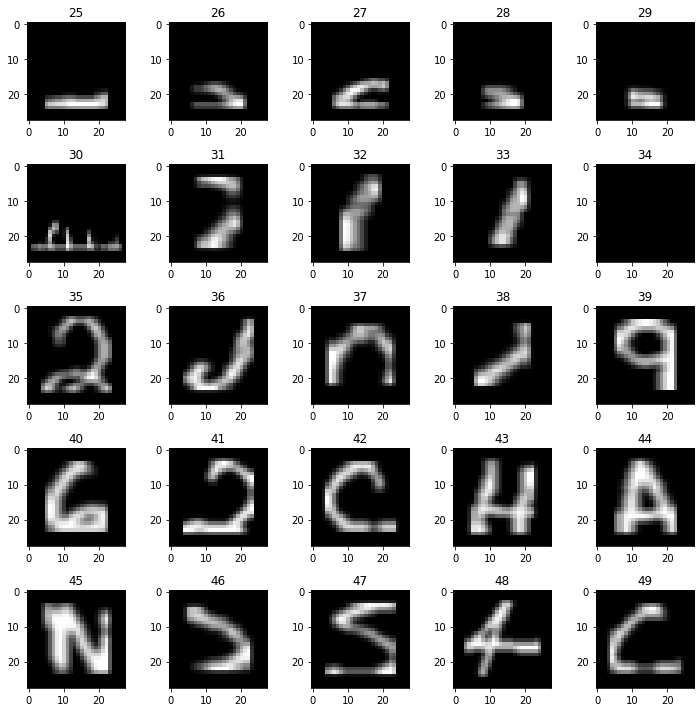

In [16]:
# Plot 4 columns and 4 rows for a subplot
plt_cols = 5
plt_rows = 5

# Start at image #100 of our test_x dataset
row_to_start = 25

# Create a figure, where each figure has a size (8,8)
fig=plt.figure(figsize=(10, 10))


# # iterate between row_to_start to the amount of rows and cols we have created
# for i in range(row_to_start, row_to_start + plt_cols*plt_rows):
#     # each plot will initate the same rows and cols, for the 3rd param we will iterate from 1 to (rows * cols)
#     fig.add_subplot(plt_rows, plt_cols, i - row_to_start + 1)
#     fig.tight_layout()
#     #image to show is the train_x
#     plt.imshow(train_x[i], cmap=plt.get_cmap('gray'))
#     plt.title(class_mapping[train_y[i]])
# plt.show()


# iterate between row_to_start to the amount of rows and cols we have created
for i in range(row_to_start, row_to_start + plt_cols*plt_rows):
    # each plot will initate the same rows and cols, for the 3rd param we will iterate from 1 to (rows * cols)
    fig.add_subplot(plt_rows, plt_cols, i - row_to_start + 1)
    fig.tight_layout()
    #image to show is the test_x
    plt.imshow(test_x[i], cmap=plt.get_cmap('gray'))
    plt.title(i)
plt.show()

## 3. Prepare these datasets for the ML algorithm

We will provide [One Hot Encoding](https://hackernoon.com/what-is-one-hot-encoding-why-and-when-do-you-have-to-use-it-e3c6186d008f) to the ML algorithm so that the neural network does a better job in prediction.

In [17]:
# train_y = utils.to_categorical(train_y, class_num)
test_y = utils.to_categorical(test_y, class_num)

The `conv2d` layer in the neural network that will be created expects 4 dimensions for the input, which will be the `train_x` and `test_x` datasets. These input arrays will also be reshaped accordingly.

In [18]:
# train_x = train_x.reshape(-1, HEIGHT, WIDTH, 1)
test_x = test_x.reshape(-1, HEIGHT, WIDTH, 1)
# print(train_x.shape)
print(test_x.shape)

(1001, 28, 28, 1)


### Final Model vs Test Dataset

The `test_x` dataset (the dataset that the model has never seen) has been ran against the final model, `model_1.h1`, to calculate the final accuracy.

In [19]:
import tensorflow.keras as keras

model = keras.models.load_model("models/model_2.h5")

predictions = model.predict_classes(test_x)

final_model_predictions = model.predict(test_x)
print(type(predictions))



Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
<class 'numpy.ndarray'>


In [20]:
field_name = field_name.to_numpy()
print(field_name)
print(type(field_name))
print(type(predictions))
print(len(predictions))

['WRITEUP NO.' 'PHOTO NO.' 'PHOTO NO.' ... 'PALLET_GROUPS_10'
 'PALLET_GROUPS_10' 'PALLET_GROUPS_10']
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
1001


In [21]:
matchings = np.c_[predictions, field_name]
matchings

array([[2, 'WRITEUP NO.'],
       [14, 'PHOTO NO.'],
       [21, 'PHOTO NO.'],
       ...,
       [18, 'PALLET_GROUPS_10'],
       [18, 'PALLET_GROUPS_10'],
       [18, 'PALLET_GROUPS_10']], dtype=object)

In [22]:
# this dictionary will hold the predictions for each field in the form

pred_data = {}


for name in field_name:
    pred_data[name] = {'guesses' : [], 'pred_list': []}

In [23]:
pred_data

{'WRITEUP NO.': {'guesses': [], 'pred_list': []},
 'PHOTO NO.': {'guesses': [], 'pred_list': []},
 'FOREST': {'guesses': [], 'pred_list': []},
 'RANGER DISTRICT': {'guesses': [], 'pred_list': []},
 'ALLOTMENT': {'guesses': [], 'pred_list': []},
 'EXAMINER': {'guesses': [], 'pred_list': []},
 'DATE': {'guesses': [], 'pred_list': []},
 'TRANSECT NO.': {'guesses': [], 'pred_list': []},
 'PLOT SIZE': {'guesses': [], 'pred_list': []},
 'PLOT INTERVAL': {'guesses': [], 'pred_list': []},
 'TYPE DESIGNATION': {'guesses': [], 'pred_list': []},
 'KIND OF LIVESTOCK': {'guesses': [], 'pred_list': []},
 'SLOPE': {'guesses': [], 'pred_list': []},
 'ASPECT': {'guesses': [], 'pred_list': []},
 'LOCATION': {'guesses': [], 'pred_list': []},
 'SPECIES_0': {'guesses': [], 'pred_list': []},
 'SPECIES_1': {'guesses': [], 'pred_list': []},
 'SPECIES_2': {'guesses': [], 'pred_list': []},
 'SPECIES_3': {'guesses': [], 'pred_list': []},
 'SPECIES_4': {'guesses': [], 'pred_list': []},
 'SPECIES_5': {'guesses': [

In [24]:
def correct_percentage_on_test_verbose(predictions):
    correct = 0
    incorrect = 0

    for x in range(len(test_y)):
       
      
        if np.argmax(predictions[x]) == np.argmax(test_y[x]):
            print(x)
            print("guess: ", np.argmax(predictions[x]), "--> ", chr(mapp[np.argmax(predictions[x])]))
            print("class: ", np.argmax(test_y[x]),  "--> ", chr(mapp[np.argmax(test_y[x])]))
            correct += 1
            print("## correct")
        else:
            print(x)
            print("guess: ", np.argmax(predictions[x]), "--> ", chr(mapp[np.argmax(predictions[x])]))
            print("class: ", np.argmax(test_y[x]),  "--> ", chr(mapp[np.argmax(test_y[x])]))
            incorrect += 1
            print("incorrect")

    # print(correct, incorrect)
    return (correct / (correct + incorrect)) * 100

def correct_percentage_on_test(predictions):
    correct = 0
    incorrect = 0

    for x in range(len(test_y)):
        if np.argmax(predictions[x]) == np.argmax(test_y[x]):
            correct += 1
        else:
            incorrect += 1

    # print(correct, incorrect)
    return (correct / (correct + incorrect)) * 100

def top_3(predictions):
    all_values = []
    all_pos = []
    
    for x in range(len(test_y)):
        ranks = sorted( [(x,i) for (i,x) in enumerate(predictions[x])], reverse=True )
        values = []
        posns = []
        for x,i in ranks:
            if x not in values:
                values.append( x )
                posns.append( i )
                if len(values) == 47:
                    break
        all_values.append(values)
        all_pos.append(posns)
    return all_values, all_pos

def correct_percentage_on_test_multiple(predictions, values, pos):
    correct = 0
    incorrect = 0
    

    for x in range(len(test_y)):
        preds = []
        for pred in pos[x]:
            preds.append(chr(mapp[pred]))
        
#         print(matchings[x][1])

        if np.argmax(predictions[x]) == np.argmax(test_y[x]):
            print("\n")
            print(f"{x})")
            print("guess: ", np.argmax(predictions[x]), "--> ", chr(mapp[np.argmax(predictions[x])]))
            print("class: ", np.argmax(test_y[x]),  "--> ", chr(mapp[np.argmax(test_y[x])]))
            print("Field_name: ", matchings[x][1])
            correct += 1
            print("## correct")
            pred_data[matchings[x][1]]['guesses'].append(chr(mapp[np.argmax(predictions[x])]))
            pred_data[matchings[x][1]]['pred_list'].append(preds)
        else:
            print("\n")
            print(f"{x})")
            print("guess: ", np.argmax(predictions[x]), "--> ", chr(mapp[np.argmax(predictions[x])]))
            print("class: ", np.argmax(test_y[x]),  "--> ", chr(mapp[np.argmax(test_y[x])]))
            print("Field_name: ", matchings[x][1])
            print(preds)
            pred_data[matchings[x][1]]['guesses'].append(chr(mapp[np.argmax(predictions[x])]))
            pred_data[matchings[x][1]]['pred_list'].append(preds)

            incorrect += 1
            print("incorrect")



    # print(correct, incorrect)
    return (correct / (correct + incorrect)) * 100


In [25]:
values, pos = top_3(final_model_predictions)

correct_percentage_on_test_multiple(final_model_predictions, values, pos)



0)
guess:  2 -->  2
class:  0 -->  0
Field_name:  WRITEUP NO.
['2', 'Z', 'a', 'I', '1', 'L', 'U', 'd', '7', '3', 'J', 't', 'N', 'D', '8', '0', 'q', 'e', 'X', 'O', 'n', 'C', 'T', 'V', 'F', 'h', 'B', 'E', 'S', 'f', 'b', 'A', 'g', 'H', '5', 'R', 'Q', 'Y', 'G', 'P', '6', 'W', '4', 'r', 'K', '9', 'M']
incorrect


1)
guess:  14 -->  E
class:  0 -->  0
Field_name:  PHOTO NO.
['E', 'e', 'F', 'f', 't', 'C', 'I', 'K', 'S', 'G', 'Z', '5', 'X', '8', 'L', 'q', 'g', 'r', 'J', 'a', 'B', 'b', 'R', 'T', 'H', '6', '4', 'O', '1', '2', 'd', 'Q', 'h', 'N', 'Y', '0', 'W', 'A', 'V', 'D', 'U', '3', 'P', 'n', 'M', '9', '7']
incorrect


2)
guess:  21 -->  L
class:  0 -->  0
Field_name:  PHOTO NO.
['L', 'J', 'I', '2', 'd', '1', '6', 'a', 'f', 't', '0', 'C', 'F', 'b', 'U', 'Z', 'G', 'h', 'S', 'O', 'N', 'g', 'q', 'D', 'e', 'W', 'T', 'E', '3', '7', 'n', 'A', '5', 'H', 'Q', 'V', '8', '4', 'X', 'P', 'K', 'B', 'r', 'Y', '9', 'R', 'M']
incorrect


3)
guess:  12 -->  C
class:  0 -->  0
Field_name:  PHOTO NO.
['C', 'I'

0.0

In [26]:
pred_data

{'WRITEUP NO.': {'guesses': ['2'],
  'pred_list': [['2',
    'Z',
    'a',
    'I',
    '1',
    'L',
    'U',
    'd',
    '7',
    '3',
    'J',
    't',
    'N',
    'D',
    '8',
    '0',
    'q',
    'e',
    'X',
    'O',
    'n',
    'C',
    'T',
    'V',
    'F',
    'h',
    'B',
    'E',
    'S',
    'f',
    'b',
    'A',
    'g',
    'H',
    '5',
    'R',
    'Q',
    'Y',
    'G',
    'P',
    '6',
    'W',
    '4',
    'r',
    'K',
    '9',
    'M']]},
 'PHOTO NO.': {'guesses': ['E', 'L', 'C', 't', '3', '3'],
  'pred_list': [['E',
    'e',
    'F',
    'f',
    't',
    'C',
    'I',
    'K',
    'S',
    'G',
    'Z',
    '5',
    'X',
    '8',
    'L',
    'q',
    'g',
    'r',
    'J',
    'a',
    'B',
    'b',
    'R',
    'T',
    'H',
    '6',
    '4',
    'O',
    '1',
    '2',
    'd',
    'Q',
    'h',
    'N',
    'Y',
    '0',
    'W',
    'A',
    'V',
    'D',
    'U',
    '3',
    'P',
    'n',
    'M',
    '9',
    '7'],
   ['L',
    'J',
    'I',
    

In [27]:
# write the field-predictins matchings to a JSON file
import json

with open("field_preds.json", "w") as outfile:
    json.dump(pred_data, outfile)

In [411]:
# model_1 = keras.models.load_model("models/model_1.h5") # 2-conv-128-nodes-2-dense-0.2-Dropout
model_2 = keras.models.load_model("models/model_2.h5") # 2-conv-128-nodes-2-dense-0.2-Dropout
# model_3 = keras.models.load_model("models/model_3.h5") # 2-conv-64-nodes-2-dense-0.2-Dropout
# model_4 = keras.models.load_model("models/model_4.h5") # 2-conv-64-nodes-2-dense-0.2-Dropout
# model_5 = keras.models.load_model("models/model_5.h5")# 2-conv-64-nodes-2-dense-0.2-Dropout

In [412]:
# prediction_1 = model_1.predict(test_x)
prediction_2 = model_2.predict(test_x)
# prediction_3 = model_3.predict(test_x)
# prediction_4 = model_4.predict(test_x)
# prediction_5 = model_5.predict(test_x)

In [413]:
# model_1_correct = correct_percentage_on_test(prediction_1)
model_2_correct = correct_percentage_on_test(prediction_2)
# model_3_correct = correct_percentage_on_test(prediction_3)
# model_4_correct = correct_percentage_on_test(prediction_4)
# model_5_correct = correct_percentage_on_test(prediction_5)

print('Accuracy of all 5 models used inside web application\n')
# print('Model #1: {}%'.format(model_1_correct))
print('Model #2: {}%'.format(model_2_correct))
# print('Model #3: {}%'.format(model_3_correct))
# print('Model #4: {}%'.format(model_4_correct))
# print('Model #5: {}%'.format(model_5_correct))

Accuracy of all 5 models used inside web application

Model #2: 0.0%


This section displays the accuracy of all 5 models working together to create one prediction.

The resulting output of `model_jury_ruling` will be the most popular prediction between the 5 models. If there is a tie between predictions, the item predicted first receives precedence. This operation works in this case, because the first 2 models are known to be more accurate than the last 3 models.

In [226]:
def make_prediction(model, img):
    prediction = model.predict(img)
    idx_prediction = np.argmax(prediction[0])
    return class_mapping[idx_prediction]

def model_jury_ruling(*argv):
    all_predictions = []
    for arg in argv:
        all_predictions.append(arg)

    hash = {}

    for prediction in all_predictions:
        if prediction not in hash:
            hash[prediction] = 1
        else:
            hash[prediction] += 1

    # print(hash)
    

    # If all models do not have a unanimous vote, majority rules
    # Note: If there is a tie, the first item of the tie that is added gets priority over rest of the items
    return max(hash, key=hash.get)

In [227]:
combined_correct = 0
combined_incorrect = 0

for i in range(len(test_y)):
    # model_1_pred = np.argmax(prediction_1[i])
    model_2_pred = np.argmax(prediction_2[i])
    # model_3_pred = np.argmax(prediction_3[i])
    # model_4_pred = np.argmax(prediction_4[i])
    # model_5_pred = np.argmax(prediction_5[i])

    combined_model_prediction = model_jury_ruling(model_2_pred)
    # print(combined_model_prediction)

    if combined_model_prediction == np.argmax(test_y[i]):
        combined_correct += 1
    else:
        combined_incorrect += 1

accuracy_of_combined_models = (combined_correct / (combined_correct + combined_incorrect))* 100
print('Accuracy of combined models: {}%'.format(accuracy_of_combined_models))

Accuracy of combined models: 0.0%
